<a href="https://colab.research.google.com/github/JJF1962/Module-20-test/blob/main/songs_normalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (86.1 kB/s)
Reading package l

In [2]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from google.colab import files
uploaded = files.upload()


#  Import and read the songs_normalize.csv.
import pandas as pd 
application_df = pd.read_csv("songs_normalize.csv")
application_df.head()

Saving songs_normalize.csv to songs_normalize (3).csv


,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [4]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-06-11 13:16:07--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.3’

postgresql-42.2.16. 100%[===================>] 979.38K  1.22MB/s    in 0.8s    

2022-06-11 13:16:09 (1.22 MB/s) - ‘postgresql-42.2.16.jar.3’ saved [1002883/1002883]



In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M20-Challenge1").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

Load Data into Spark DataFrame

In [6]:
# Drop the non-beneficial ID columns, 'explicit' and 'song'

application_df = application_df.drop(["explicit","song"], axis = 1)
application_df.head(10)

,artist,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,211160,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.30000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,167066,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.01030,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,250546,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.17300,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,224493,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.02630,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,200560,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.04080,0.001040,0.0845,0.879,172.656,pop
5,Sisqo,253733,1999,69,0.706,0.888,2,-6.959,1,0.0654,0.11900,0.000096,0.0700,0.714,121.549,"hip hop, pop, R&B"
6,Eminem,284200,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.000000,0.0454,0.760,104.504,hip hop
7,Robbie Williams,258560,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.02670,0.000000,0.4670,0.861,103.035,"pop, rock"
8,Destiny's Child,271333,1999,75,0.713,0.678,5,-3.525,0,0.1020,0.27300,0.000000,0.1490,0.734,138.009,"pop, R&B"
9,Modjo,307153,2001,77,0.720,0.808,6,-5.627,1,0.0379,0.00793,0.029300,0.0634,0.869,126.041,Dance/Electronic


In [7]:
# Determine the number of unique values in each column.

application_df.nunique()

artist               835
duration_ms         1793
year                  23
popularity            76
danceability         565
energy               580
key                   12
loudness            1671
mode                   2
speechiness          837
acousticness        1208
instrumentalness     772
liveness             783
valence              760
tempo               1831
genre                 59
dtype: int64

In [25]:
# Look at APPLICATION_TYPE value counts for binning
popularity_type = application_df.popularity.value_counts()
popularity_type

Other    2000
Name: popularity, dtype: int64

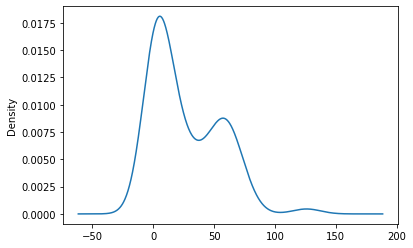

In [29]:
# Visualize the value counts of APPLICATION_TYPE

app_type.plot.density()

In [27]:
# Determine which values to replace if counts are less than ...?

replace_application = list(app_type[app_type < 200].index)
# Replace in dataframe
for app in replace_application:
    application_df.popularity = application_df.popularity.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.popularity.value_counts()

Other    2000
Name: popularity, dtype: int64

In [30]:
artist_type = application_df.artist.value_counts()
artist_type

Other    2000
Name: artist, dtype: int64

In [31]:
application_df.dtypes

artist               object
duration_ms          object
year                  int64
popularity           object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object

In [35]:
# Generate our categorical variable lists

artist_list = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

In [37]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list


encode_df = pd.DataFrame(enc.fit_transform(application_df[artist_list]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(artist_list)
encode_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,artist_Other,duration_ms_Other,popularity_Other,genre_Dance/Electronic,"genre_Folk/Acoustic, pop","genre_Folk/Acoustic, rock","genre_Folk/Acoustic, rock, pop",genre_R&B,"genre_World/Traditional, Folk/Acoustic","genre_World/Traditional, hip hop",...,"genre_rock, blues","genre_rock, blues, latin","genre_rock, classical","genre_rock, easy listening","genre_rock, metal","genre_rock, pop","genre_rock, pop, Dance/Electronic","genre_rock, pop, metal","genre_rock, pop, metal, Dance/Electronic",genre_set()
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(artist_list,1)
application_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,"genre_rock, blues","genre_rock, blues, latin","genre_rock, classical","genre_rock, easy listening","genre_rock, metal","genre_rock, pop","genre_rock, pop, Dance/Electronic","genre_rock, pop, metal","genre_rock, pop, metal, Dance/Electronic",genre_set()
0,2000,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1999,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2000,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Split our preprocessed data into our features and target arrays
y = application_df["key"].values
X = application_df.drop(["key"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                5920      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,381
Trainable params: 8,381
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [44]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [45]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [47]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
47/47 [==============================] - 1s 2ms/step - loss: -3762.6279 - accuracy: 0.1313
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: -16948.9609 - accuracy: 0.1313
Epoch 3/100
47/47 [==============================] - 0s 3ms/step - loss: -51477.4727 - accuracy: 0.1313
Epoch 4/100
47/47 [==============================] - 0s 3ms/step - loss: -126937.1484 - accuracy: 0.1313
Epoch 5/100
47/47 [==============================] - 0s 3ms/step - loss: -264211.3125 - accuracy: 0.1313
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: -483279.0312 - accuracy: 0.1313
Epoch 7/100
47/47 [==============================] - 0s 3ms/step - loss: -805523.5625 - accuracy: 0.1313
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: -1249905.6250 - accuracy: 0.1313
Epoch 9/100
47/47 [==============================] - 0s 3ms/step - loss: -1833025.5000 - accuracy: 0.1313
Epoch 10/100
47/47 [==============================] - 0s 

In [48]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

16/16 - 0s - loss: -1.3313e+06 - accuracy: 0.1400 - 288ms/epoch - 18ms/step
Loss: -1331311.5, Accuracy: 0.14000000059604645


In [49]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 100
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               7400      
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 10,461
Trainable params: 10,461
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization_change_activ/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_change_activ/weights.{epoch:02d}hdf5"
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 7ms/step - loss: -14.5007 - accuracy: 0.1307
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: -72.1079 - accuracy: 0.1313
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: -236.6719 - accuracy: 0.1313
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: -614.9601 - accuracy: 0.1313
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -1323.5945 - accuracy: 0.1313
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: -2481.5874 - accuracy: 0.1313
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: -4211.3071 - accuracy: 0.1313
Epoch 8/100
47/47 [==============================] - 0s 5ms/step - loss: -6607.8154 - accuracy: 0.1313
Epoch 9/100
47/47 [==============================] - 0s 5ms/step - loss: -9794.2363 - accuracy: 0.1313
Epoch 10/100
47/47 [==============================] - 0s 6ms/step - loss: -1385

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

16/16 - 0s - loss: -8.5851e+06 - accuracy: 0.1400 - 286ms/epoch - 18ms/step
Loss: -8585106.0, Accuracy: 0.14000000059604645


In [53]:
# Export our model to HDF5 file
from google.colab import files
nn.save("songs_normalized_optimized.h5")
files.download("songs_normalized_optimized.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>